In [7]:
# Importing all necessary libraries
%load_ext autoreload
%autoreload 2

# internal packages
import os
from collections import Counter, OrderedDict

# external packages
import torch
import torchvision
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# util functions
from util.util import *

# autoencoder
from models.autoencoder.conv_ae import ConvAE
from models.simclr.simclr import *
from models.simclr.transforms import *
from models.rotnet.rotnet import *
from models.rotnet.DEC import *
from models.rotnet.custom_stl10 import *
from util.cluster_accuracy import cluster_accuracy
from models.simclr.custom_stl10 import SimCLRSTL10
from models.simclr.custom_fmnist import SimCLRFMNIST

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [9]:
print("Versions:")
print(f"torch: {torch.__version__}")
print(f"torchvision: {torchvision.__version__}")
print(f"numpy: {np.__version__}",)
print(f"scikit-learn: {sklearn.__version__}")

device = detect_device()
print("Using device: ", device)

Versions:
torch: 1.8.1+cu111
torchvision: 0.9.1+cu111
numpy: 1.19.5
scikit-learn: 0.24.1
Using device:  cuda


## Preparation

In [4]:
# specify learning params
batch_size = 128
learning_rate = 0.1
epochs = 100

# training

train = True

In [102]:
cifar_test_data = load_util.load_custom_cifar('./data', download=False, train=False, data_percent=1.0, for_model='SimCLR', transforms=False)
cifar_testloader = torch.utils.data.DataLoader(cifar_test_data,
                                          batch_size=128,
                                          shuffle=True,
                                          drop_last=True)

In [103]:
cifar_colors_classes = {i: color_class for i, color_class in zip(range(len(cifar_test_data.classes)), cifar_test_data.classes)}

In [24]:
stl10_test_data = SimCLRSTL10(data_percent=1.0, train=False)
stl10_testloader = torch.utils.data.DataLoader(stl10_test_data,
                                         batch_size=128,
                                         shuffle=True,
                                         drop_last=True)

In [25]:
stl10_colors_classes = {i: color_class for i, color_class in zip(range(len(stl10_test_data.class_names)), stl10_test_data.class_names)}

In [115]:
fmnist_test_data = SimCLRFMNIST('./data', data_percent=1.0, train=False, download=True)
fmnist_testloader = torch.utils.data.DataLoader(fmnist_test_data,
                                         batch_size=128,
                                         shuffle=True,
                                         drop_last=True)

In [116]:
fmnist_colors_classes = {i: color_class for i, color_class in zip(range(len(fmnist_test_data.classes)), fmnist_test_data.classes)}

In [125]:
def get_nmis_and_cas_10_runs(model_name, colors_classes, device, dataset='CIFAR', model_range=range(10), run_range=range(10)):
    nmis = {}
    cas = {}
    
    tls = {
        'CIFAR': cifar_testloader,
        'FMNIST': fmnist_testloader,
        'STL10':stl10_testloader
    }
    testloader = tls[dataset]
    # testloader = cifar_testloader if 'CIFAR' in dataset else stl10_testloader

    for i in model_range:
        name = f'{model_name}_{i}.pth'
        print(name)

        model = load_model(name, device)
        nmis[i] = []
        cas[i] = []

        for k in run_range:
            labels, kmeans, nmi, _, _ = compute_nmi_and_pca(model, name, colors_classes, device, testloader)
            nmis[i].append(nmi)

            ca = cluster_accuracy(labels, kmeans.labels_)
            cas[i].append(ca)
            print(f'Run: {k}\n{name}:\nNMI:{nmi}\nCA:{ca}\n')
            del labels
            del kmeans
    return nmis, cas

In [96]:
def print_total_mean_and_var(metrics_name, df):
    models_means = df.mean()

    total_mean = models_means.mean()
    total_std = models_means.std()
    
    print(f'{metrics_name} mean: {total_mean:.4f}')
    print(f'{metrics_name} variance: {total_std:.4f}')

In [100]:
def compute_everything(path_nmis, path_cas, model_name, colors_classes, compute=True, dataset='CIFAR', model_range=range(10), run_range=range(10)):
    if compute: 
        df_nmis, df_cas = get_nmis_and_cas_10_runs(model_name, colors_classes, device, dataset=dataset, model_range=model_range, run_range=run_range)

        df_nmis = pd.DataFrame(df_nmis)
        df_cas = pd.DataFrame(df_cas)
        
        df_nmis.to_csv(path_nmis)
        df_cas.to_csv(path_cas)
    
    df_nmis = pd.read_csv(path_nmis, index_col=0)
    df_cas = pd.read_csv(path_cas, index_col=0)

    print_total_mean_and_var('NMI', df_nmis)
    print_total_mean_and_var('Cluser accuracy', df_cas)
    
    return df_nmis, df_cas

## RotNet

### CIFAR : Pretraining

In [110]:
path_nmis = 'trained_models/RotNet/CIFAR/nmis.csv'
path_cas = 'trained_models/RotNet/CIFAR/cas.csv'

Uncomment this part to generate new NMI and cluster accuracies

In [ ]:
# rotnet_nmis_cifar, rotnet_cas_cifar = get_nmis_and_cas_10_runs('RotNet\CIFAR\pretrained_RotNet', colors_classes, device)

In [ ]:
# df_rotnet_nmis_cifar = pd.DataFrame(rotnet_nmis_cifar)
# df_rotnet_cas_cifar = pd.DataFrame(rotnet_cas_cifar)

In [74]:
# df_rotnet_nmis_cifar.to_csv(path_nmis)
# df_rotnet_cas_cifar.to_csv(path_cas)

This code loads existing dataframes from specified paths

In [111]:
df_rotnet_nmis_cifar = pd.read_csv(path_nmis, index_col=0)
df_rotnet_cas_cifar = pd.read_csv(path_cas, index_col=0)

In [112]:
print_total_mean_and_var('NMI', df_rotnet_nmis_cifar)

NMI mean: 0.3506
NMI variance: 0.0017


In [113]:
print_total_mean_and_var('Cluser accuracy', df_rotnet_cas_cifar)

Cluser accuracy mean: 0.4357
Cluser accuracy variance: 0.0051


### CIFAR: DEC

In [114]:
path_nmis = 'trained_models/RotNet/CIFAR/nmis_dec.csv'
path_cas = 'trained_models/RotNet/CIFAR/cas_dec.csv'

Uncomment this part to generate new NMI and cluster accuracies

In [ ]:
# rotnet_nmis_cifar_dec, rotnet_cas_cifar_dec = get_nmis_and_cas_10_runs('RotNet\CIFAR\DEC_RotNet', colors_classes, device)

In [ ]:
# df_rotnet_nmis_cifar_dec = pd.DataFrame(rotnet_nmis_cifar_dec)
# df_rotnet_cas_cifar_dec = pd.DataFrame(rotnet_cas_cifar_dec)

In [105]:
# df_rotnet_nmis_cifar_dec.to_csv(path_nmis)
# df_rotnet_cas_cifar_dec.to_csv(path_cas)

This code loads existing dataframes from specified paths

In [115]:
df_rotnet_nmis_cifar_dec = pd.read_csv(path_nmis, index_col=0)
df_rotnet_cas_cifar_dec = pd.read_csv(path_cas, index_col=0)

In [117]:
print_total_mean_and_var('NMI', df_rotnet_nmis_cifar_dec)

NMI mean: 0.1042
NMI variance: 0.0001


In [118]:
print_total_mean_and_var('Cluser accuracy', df_rotnet_cas_cifar_dec)

Cluser accuracy mean: 0.2065
Cluser accuracy variance: 0.0002


### STL10: Pretraining

In [14]:
path_nmis = 'trained_models/RotNet/STL10/nmis.csv'
path_cas = 'trained_models/RotNet/STL10/cas.csv'

Uncomment this part to generate new NMI and cluster accuracies

In [ ]:
rotnet_nmis_stl10, rotnet_cas_stl10 = get_nmis_and_cas_10_runs('RotNet\STL10\pretrained_RotNet_STL10', stl10_colors_classes, device, dataset='STL10')

In [33]:
df_rotnet_nmis_stl10 = pd.DataFrame(rotnet_nmis_stl10)
df_rotnet_cas_stl10 = pd.DataFrame(rotnet_cas_stl10)

In [34]:
df_rotnet_nmis_stl10.to_csv(path_nmis)
df_rotnet_cas_stl10.to_csv(path_cas)

In [35]:
df_rotnet_nmis_stl10 = pd.read_csv(path_nmis, index_col=0)
df_rotnet_cas_stl10 = pd.read_csv(path_cas, index_col=0)

In [36]:
print_total_mean_and_var('NMI', df_rotnet_nmis_stl10)

NMI mean: 0.3357
NMI variance: 0.0032


In [37]:
print_total_mean_and_var('Cluser accuracy', df_rotnet_cas_stl10)

Cluser accuracy mean: 0.3641
Cluser accuracy variance: 0.0076


### STL10: DEC

In [39]:
path_nmis = 'trained_models/RotNet/STL10/nmis_dec.csv'
path_cas = 'trained_models/RotNet/STL10/cas_dec.csv'

Uncomment this part to generate new NMI and cluster accuracies

In [ ]:
# rotnet_nmis_stl10_dec, rotnet_cas_stl10_dec = get_nmis_and_cas_10_runs('RotNet\STL10\DEC_RotNet_STL10', stl10_colors_classes, device, dataset='STL10')

In [41]:
# df_rotnet_nmis_stl10_dec = pd.DataFrame(rotnet_nmis_stl10_dec)
# df_rotnet_cas_stl10_dec = pd.DataFrame(rotnet_cas_stl10_dec)

In [42]:
# df_rotnet_nmis_stl10_dec.to_csv(path_nmis)
# df_rotnet_cas_stl10_dec.to_csv(path_cas)

In [43]:
df_rotnet_nmis_stl10_dec = pd.read_csv(path_nmis, index_col=0)
df_rotnet_cas_stl10_dec = pd.read_csv(path_cas, index_col=0)

In [44]:
print_total_mean_and_var('NMI', df_rotnet_nmis_stl10_dec)

NMI mean: 0.1292
NMI variance: 0.0003


In [45]:
print_total_mean_and_var('Cluser accuracy', df_rotnet_cas_stl10_dec)

Cluser accuracy mean: 0.1967
Cluser accuracy variance: 0.0003


### FMNIST: Pretraining

In [79]:
path_nmis = 'trained_models/RotNet/FMNIST/nmis.csv'
path_cas = 'trained_models/RotNet/FMNIST/cas.csv'
model_name = 'RotNet/FMNIST/pretrained_RotNet_FMNIST'

In [ ]:
df_nmis, df_cas = compute_everything(path_nmis, path_cas, model_name, fmnist_colors_classes, compute=True, dataset='FMNIST')

In [133]:
path_nmis = 'trained_models/RotNet/FMNIST/nmis_dec.csv'
path_cas = 'trained_models/RotNet/FMNIST/cas_dec.csv'
model_name = 'RotNet/FMNIST/DEC_RotNet_FMINST'

In [ ]:
df_nmis, df_cas = compute_everything(path_nmis, path_cas, model_name, fmnist_colors_classes, compute=True, dataset='FMNIST')

## SimCLR

### CIFAR: Pretraining

In [130]:
path_nmis = 'trained_models/SimCLR/CIFAR/nmis.csv'
path_cas = 'trained_models/SimCLR/CIFAR/cas.csv'

Uncomment this part to generate new NMI and cluster accuracies

In [ ]:
# simclr_nmis_cifar, simclr_cas_cifar = get_nmis_and_cas_10_runs('SimCLR\CIFAR\pretrained_SimCLR', colors_classes, device)

In [24]:
# df_simclr_nmis_cifar = pd.DataFrame(simclr_nmis_cifar)
# df_simclr_cas_cifar = pd.DataFrame(simclr_cas_cifar)

In [134]:
# df_simclr_nmis_cifar.to_csv(path_nmis)
# df_simclr_cas_cifar.to_csv(path_cas)

In [132]:
df_simclr_nmis_cifar = pd.read_csv(path_nmis, index_col=0)
df_simclr_cas_cifar = pd.read_csv(path_cas, index_col=0)

In [135]:
print_total_mean_and_var('NMI', df_simclr_nmis_cifar)

NMI mean: 0.4724
NMI variance: 0.0033


In [136]:
print_total_mean_and_var('Cluser accuracy', df_simclr_cas_cifar)

Cluser accuracy mean: 0.5904
Cluser accuracy variance: 0.0090


In [98]:
columns = [f'Run {i}' for i in range(10)]

In [133]:
df_simclr_nmis_cifar.columns = columns
df_simclr_cas_cifar.columns = columns

### CIFAR: +100 pretraining

In [22]:
path_nmis = 'trained_models/SimCLR/CIFAR/nmis_100.csv'
path_cas = 'trained_models/SimCLR/CIFAR/cas_100.csv'
model_name = 'SimCLR/CIFAR/pretrained_SimCLR_100_CIFAR'

In [33]:
df_nmis_100, df_cas_100 = compute_everything(path_nmis, path_cas, model_name, cifar_colors_classes, compute=False)

NMI mean: 0.4905
NMI variance: 0.0105
Cluser accuracy mean: 0.6106
Cluser accuracy variance: 0.0266


### CIFAR: IDEC

In [137]:
path_nmis = 'trained_models/SimCLR/CIFAR/nmis_idec.csv'
path_cas = 'trained_models/SimCLR/CIFAR/cas_idec.csv'

Uncomment this part to generate new NMI and cluster accuracies

In [ ]:
# simclr_nmis_cifar_idec, simclr_cas_cifar_idec = get_nmis_and_cas_10_runs('SimCLR\CIFAR\IDEC_SimCLR', colors_classes, device)

In [27]:
# df_simclr_nmis_cifar_idec = pd.DataFrame(simclr_nmis_cifar_idec)
# df_simclr_cas_cifar_idec = pd.DataFrame(simclr_cas_cifar_idec)

In [141]:
# df_simclr_nmis_cifar_idec.to_csv(path_nmis)
# df_simclr_cas_cifar_idec.to_csv(path_cas)

In [138]:
df_simclr_nmis_cifar_idec = pd.read_csv(path_nmis, index_col=0)
df_simclr_cas_cifar_idec = pd.read_csv(path_cas, index_col=0)

In [142]:
print_total_mean_and_var('NMI', df_simclr_nmis_cifar_idec)

NMI mean: 0.5569
NMI variance: 0.0001


In [143]:
print_total_mean_and_var('Cluser accuracy', df_simclr_cas_cifar_idec)

Cluser accuracy mean: 0.6576
Cluser accuracy variance: 0.0000


### STL10: Pretraining

In [46]:
path_nmis = 'trained_models/SimCLR/STL10/nmis.csv'
path_cas = 'trained_models/SimCLR/STL10/cas.csv'

Uncomment this part to generate new NMI and cluster accuracies

In [ ]:
# simclr_nmis_stl10, simclr_cas_stl10 = get_nmis_and_cas_10_runs('SimCLR\STL10\pretrained_SimCLR_STL10', stl10_colors_classes, device, dataset='STL10')

In [48]:
# df_simclr_nmis_stl10 = pd.DataFrame(simclr_nmis_stl10)
# df_simclr_cas_stl0 = pd.DataFrame(simclr_cas_stl10)

In [49]:
# df_simclr_nmis_stl10.to_csv(path_nmis)
# df_simclr_cas_stl0.to_csv(path_cas)

In [50]:
df_simclr_nmis_stl10 = pd.read_csv(path_nmis, index_col=0)
df_simclr_cas_stl0 = pd.read_csv(path_cas, index_col=0)

In [51]:
print_total_mean_and_var('NMI', df_simclr_nmis_stl10)

NMI mean: 0.3502
NMI variance: 0.0015


In [52]:
print_total_mean_and_var('Cluser accuracy', df_simclr_cas_stl0)

Cluser accuracy mean: 0.4114
Cluser accuracy variance: 0.0051


In [17]:
names = ['SimCLR\STL10\pretrained_SimCLR_STL10_0.pth', 'SimCLR\STL10\pretrained_SimCLR_100_STL10_0.pth', 'SimCLR\STL10\pretrained_IDEC_SimCLR_0.pth']

In [31]:
nmis = [0,0,0]
pcas = [0,0,0]
lcs = [0,0,0]

In [32]:
for i, name in enumerate(names):
    model = load_model(name, device)
    labels, kmeans, nmi, reduced_data, lable_classes = compute_nmi_and_pca(model, name, stl10_colors_classes, device, stl10_testloader)
    nmis[i] = nmi
    pcas[i] = reduced_data
    lcs[i] = lable_classes

Starting K-Means with 10 clusters...
Starting PCA with 2 components...
Starting K-Means with 10 clusters...
Starting PCA with 2 components...


D:\everything\Studium\WS2020\Bachelor\dcl_b\models\dec\DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)


Starting K-Means with 10 clusters...
Starting PCA with 2 components...


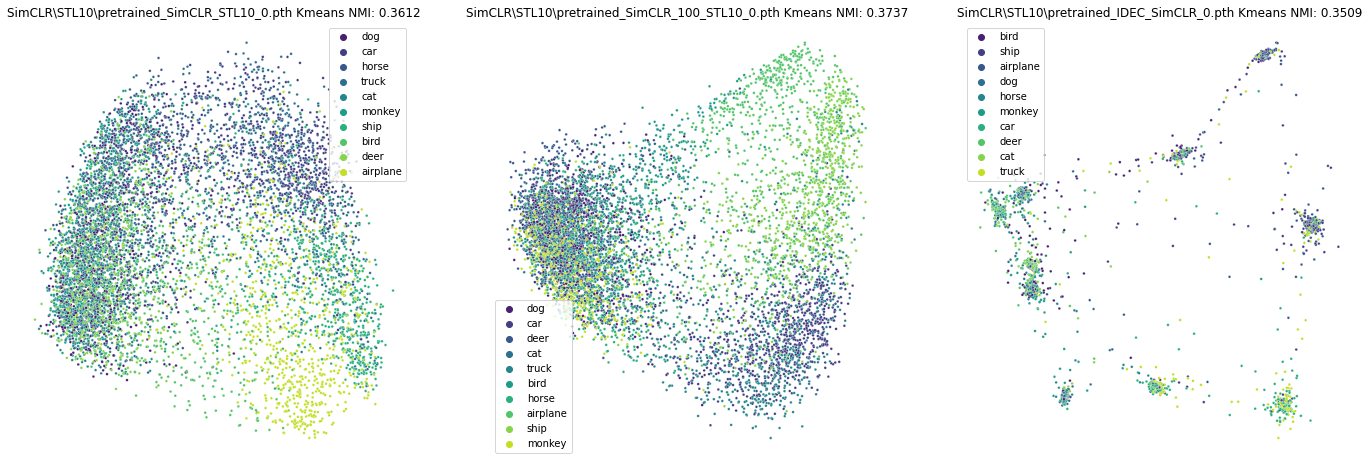

In [35]:
fig, axes = plt.subplots(1,3, figsize=(24,8))
axes = axes.flatten()

for i, name in enumerate(names):
    plot_pca_and_nmi(name, nmis[i], pcas[i], lcs[i], axes[i])

SimCLR\STL10\pretrained_SimCLR_STL10_4.pth class representation


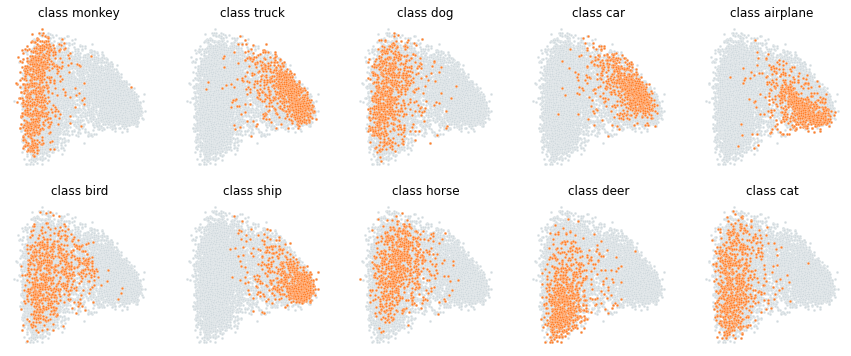

In [76]:
plot_class_representation(pca, name, lable_classes)

SimCLR\STL10\pretrained_IDEC_SimCLR_4.pth class representation


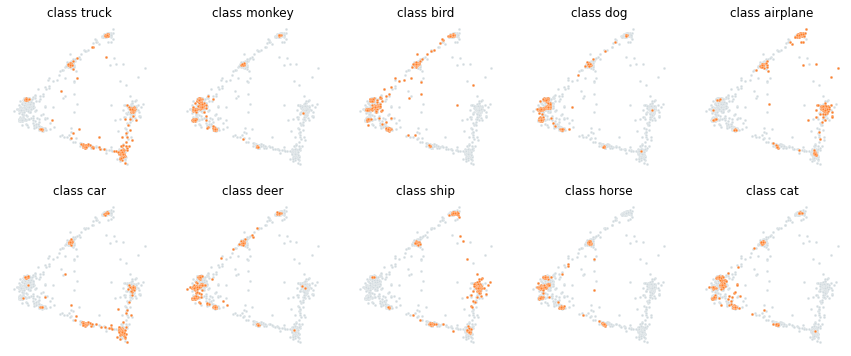

In [70]:
plot_class_representation(pca1, name1, lable_classes1)

### STL10: +100 Pretraining

In [65]:
path_nmis = 'trained_models/SimCLR/STL10/nmis_100.csv'
path_cas = 'trained_models/SimCLR/STL10/cas_100.csv'
model_name = 'SimCLR/STL10/pretrained_SimCLR_100_STL10'

In [ ]:
df_nmis_100, df_cas_100 = compute_everything(path_nmis, path_cas, model_name, stl10_colors_classes, compute=True, dataset='STL10')

### STL10: IDEC

In [129]:
path_nmis = 'trained_models/SimCLR/STL10/nmis_new.csv'
path_cas = 'trained_models/SimCLR/STL10/cas_new.csv'
model_name = 'SimCLR/STL10/pretrained_IDEC_SimCLR'

In [ ]:
df_nmis_100, df_cas_100 = compute_everything(path_nmis, path_cas, model_name, stl10_colors_classes, compute=True, dataset='STL10')

In [55]:
path_nmis_dec = 'trained_models/SimCLR/STL10/nmis_idec.csv'
path_cas_dec = 'trained_models/SimCLR/STL10/cas_idec.csv'

Uncomment this part to generate new NMI and cluster accuracies

In [ ]:
# simclr_nmis_stl10_idec, simclr_cas_stl10_idec = get_nmis_and_cas_10_runs('SimCLR\STL10\IDEC_SimCLR', stl10_colors_classes, device, dataset='STL10')

In [ ]:
# df_simclr_nmis_stl10_idec = pd.DataFrame(simclr_nmis_stl10_idec)
# df_simclr_cas_stl10_idec = pd.DataFrame(simclr_cas_stl10_idec)

In [ ]:
# df_simclr_nmis_stl10_idec.to_csv(path_nmis)
# df_simclr_cas_stl10_idec.to_csv(path_cas)

In [ ]:
df_simclr_nmis_stl10_idec = pd.read_csv(path_nmis, index_col=0)
df_simclr_cas_stl10_idec = pd.read_csv(path_cas, index_col=0)

In [ ]:
print_total_mean_and_var('NMI', df_simclr_nmis_stl10_idec)

In [ ]:
print_total_mean_and_var('Cluser accuracy', df_simclr_cas_stl10_idec)

### FMNIST: Pretraining

In [99]:
path_nmis = 'trained_models/SimCLR/FMNIST/nmis.csv'
path_cas = 'trained_models/SimCLR/FMNIST/cas.csv'
model_name = 'SimCLR/FMNIST/pretrained_SimCLR_FMNIST'

In [ ]:
df_nmis_100, df_cas_100 = compute_everything(path_nmis, path_cas, model_name, fmnist_colors_classes, compute=True, dataset='FMNIST', model_range=range(1,10))

NMI mean: 0.6163
NMI variance: 0.0049
Cluser accuracy mean: 0.6190
Cluser accuracy variance: 0.0246

### FMINST: IDEC

In [123]:
path_nmis = 'trained_models/SimCLR/FMNIST/nmis_idec.csv'
path_cas = 'trained_models/SimCLR/FMNIST/cas_idec.csv'
model_name = 'SimCLR/FMNIST/pretrained_IDEC_SimCLR'

In [ ]:
df_nmis_100, df_cas_100 = compute_everything(path_nmis, path_cas, model_name, fmnist_colors_classes, compute=True, dataset='FMNIST', model_range=range(1,10))

NMI mean: 0.6441
NMI variance: 0.0071
Cluser accuracy mean: 0.6431
Cluser accuracy variance: 0.0321